In [56]:
using Distributions, Random, KernelFunctions, LinearAlgebra
using Plots, Revise
include("helperfunctions.jl")

gppredict (generic function with 1 method)

## Generate Data

In [79]:
## Create data
Random.seed!(12781)
x_axes = collect(0:0.01:10)
niter = 20
# σ_noise = 0.4
N =2 #number of sample points

f(x) = sin.(3*x) + cos.(2*x)
y_true = f(x_axes)

#randomly sample data points
pos = sort(randperm(length(x_axes))[1:N]) 
x_data = x_axes[pos]
y_data = y_true[pos] #+ σ_noise*randn(length(pos)); 

2-element Vector{Float64}:
 -0.17700096571559376
 -1.323749527792983

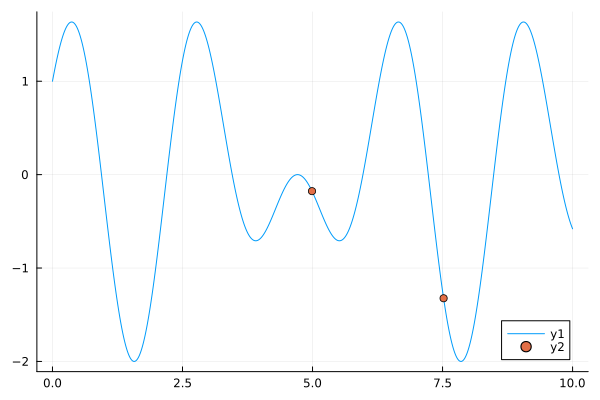

In [80]:
#visualize the true process and the data
plot(x_axes, y_true)
scatter!(x_data, y_data)

# Perform Bayesian Optimization 

In [81]:
#we should create a model for the function
kernelfunc = with_lengthscale(Matern52Kernel(), 1.)
meanfunc = (x) -> 0.0
Kff = kernelmatrix(kernelfunc,x_axes,x_axes) + 1e-6 * Diagonal(ones(length(x_axes)));

In [82]:
μ_store = [];
σ_store = [];
y_acquisition_store = [];
new_pos_store = [];

In [83]:
#fix the condition a bit
for i=1:niter
    μ, Σ = gppredict(x_data, y_data, x_axes, meanfunc, kernelfunc, Kff)
    #####
    y_acquisition = PI_acquisition(μ, Σ, y_data, 1.0)
    #####
    #sample the function value at new position
    new_pos = findall(x -> x==maximum(y_acquisition), y_acquisition) 
    y_data_new = y_true[new_pos[1]] #+ σ_noise*randn()

    #add new data to dataset
    push!(x_data, x_axes[new_pos[1]])
    push!(y_data, y_data_new)
    push!(μ_store,μ)
    push!(σ_store, sqrt.(diag(Σ) .+ 1e-6))
    push!(y_acquisition_store, y_acquisition)
    push!(new_pos_store, new_pos[1])
end

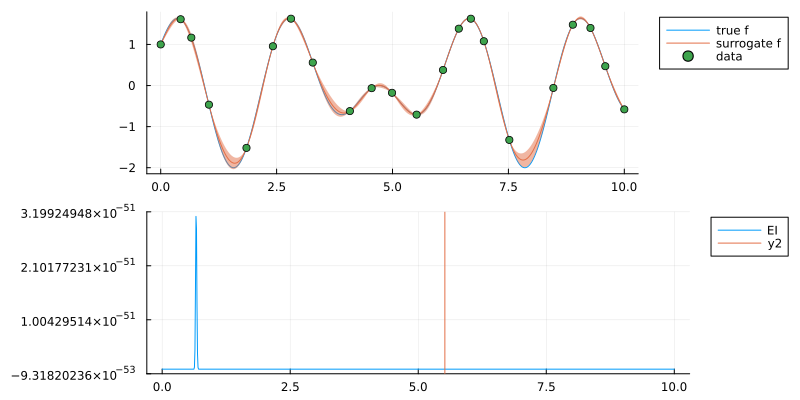

In [84]:
p1 = plot(x_axes,y_true, label = "true f")
plot!(x_axes,μ_store[end], ribbon=σ_store[end], label = "surrogate f")
scatter!(x_data, y_data, label = "data", legend = :outertopright)

p2 = plot(x_axes,y_acquisition_store[end], label="EI", legend = :outertopright)
plot!([x_axes[new_pos_store[15]]], seriestype = :vline)

plot(p1,p2, layout = (2,1), size=(800,400))

Plots.AnimatedGif("/var/folders/8j/k8hhdn6j6f98gc7nvfwmvz400000gq/T/jl_EFY5Wx03KN.gif")
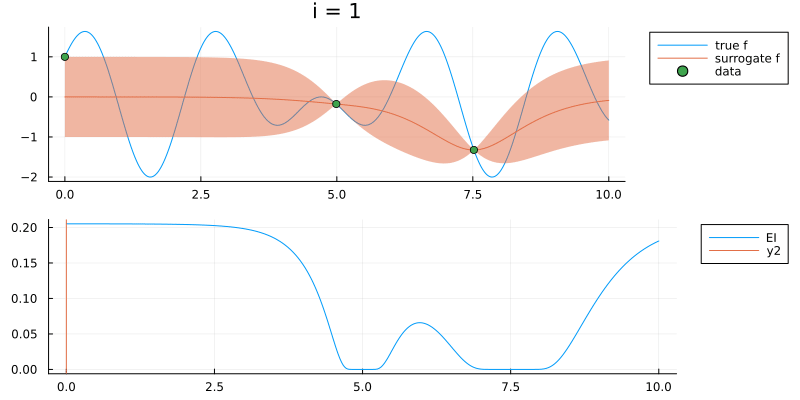

In [85]:

anim = Animation()
for i in 1:niter
    p1 = plot(x_axes,y_true, label = "true f", title="i = $(i)")
    plot!(x_axes,μ_store[i], ribbon=σ_store[i], label = "surrogate f")
    scatter!(x_data[1:(length(x_data)-niter+i)], y_data[1:(length(x_data)-niter+i)], label = "data", legend = :outertopright)
    
    p2 = plot(x_axes,y_acquisition_store[i], label="EI", legend = :outertopright)
    plot!([x_axes[new_pos_store[i]]], seriestype = :vline)
    
    plot(p1,p2, layout = (2,1), size=(800,400))
    frame(anim)
end
gif(anim; show_msg=false, fps=1)

## Do BO for 2 dimensions

In [294]:
## Create data
Random.seed!(12781)
x1_axes = 20; #number of points on the first axis  
x2_axes = 20; #number of points on the second axis
M = x1_axes * x2_axes; #total number of inducing points 
X_grid =  vec(collect(Iterators.product(range(-20,20;length=x1_axes), range(-20,20;length=x2_axes))))
X = [[i...] for i in X_grid] 
niter = 50
# σ_noise = 0.4
N =5 #number of sample points

f2d(x) = -norm(x - [-1.5,3.6],2)^2 / 2 
Y_true = f2d.(X)

pos = sort(randperm(length(X))[1:N]) 
X_data = X[pos]
Y_data = Y_true[pos]
;

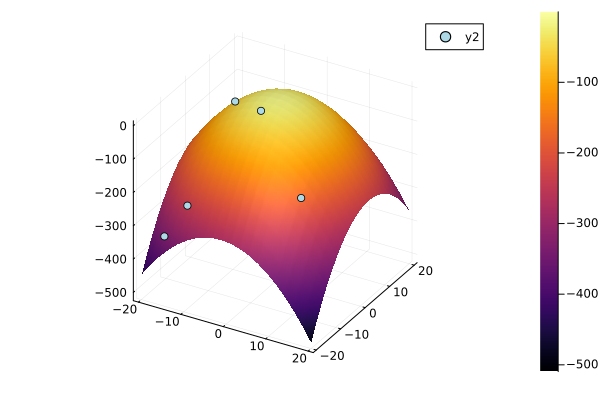

In [295]:
surface(getindex.(X,1), getindex.(X,2),Y_true)
scatter!(getindex.(X_data,1),getindex.(X_data,2),Y_data, color= :lightblue)

In [296]:
#we should create a model for the function
kernelfunc_2d = 2 * with_lengthscale(Matern52Kernel(), [3.5, 5.])
meanfunc_2d = (x) -> 0.0
Kff_2d = kernelmatrix(kernelfunc_2d,X,X) + 1e-6 * I;

In [297]:
μ_store_2d = [];
σ_store_2d = [];
y_acquisition_store_2d = [];
new_pos_store_2d = [];

In [298]:
#fix the condition a bit
for i=1:niter
    μ, Σ = gppredict(X_data, Y_data, X, meanfunc_2d, kernelfunc_2d, Kff_2d)
    #####
    y_acquisition = PI_acquisition(μ, Σ, Y_data, 4.0)
    #####
    #sample the function value at new position
    new_pos = findall(x -> x==maximum(y_acquisition), y_acquisition) 
    Y_data_new = Y_true[new_pos[1]] #+ σ_noise*randn()

    #add new data to dataset
    push!(X_data, X[new_pos[1]])
    push!(Y_data, Y_data_new)
    push!(μ_store_2d,μ)
    push!(σ_store_2d, sqrt.(diag(Σ) .+ 1e-6))
    push!(y_acquisition_store_2d, y_acquisition)
    push!(new_pos_store_2d, new_pos[1])
end

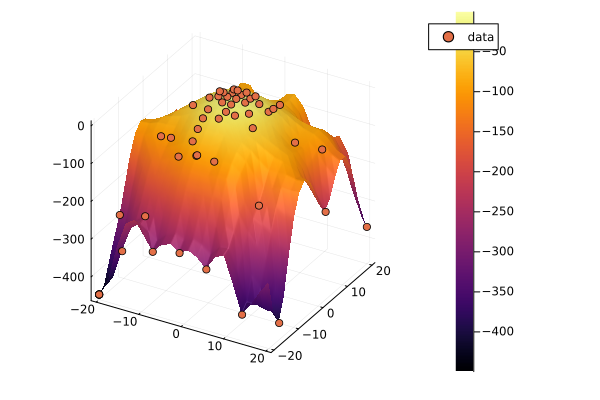

In [299]:
surface(getindex.(X,1), getindex.(X,2),μ_store_2d[end], label = "surrogate f")
scatter!(getindex.(X_data,1), getindex.(X_data,2), Y_data, label = "data", legend = :outertopright)

# p2_2d = plot(x_axes,y_acquisition_store[end], label="EI", legend = :outertopright)
# plot!([x_axes[new_pos_store[15]]], seriestype = :vline)

# plot(p1_2d,p2_2d, layout = (2,1), size=(800,400))
